In [1]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [2]:
from Train_policy_func import Policy, Policy_v2, device
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_trajectory_performance

env_name='CartPole-v0'

c:\Users\flako\Desktop\MA2\RL\Cloned_Project\RL-RLHF\Plot_Functions.py:27: DeprecationWarning: invalid escape sequence '\p'
  plt.plot(updates1, sub1, label=f"$\pi_1$ suboptimality \n mean = {np.mean(sub1):.1f}")


In [3]:
# Training loop for OPPO
from OPPO import baseline_1, OPPO_update
from Train_policy_func import Policy, device

lr_oppo = 0.01

# ── Re-instantiate a fresh policy & optimizer for OPPO ──
env_oppo   = gym.make(env_name)
policy_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
policy_oppo.load_state_dict(torch.load("pi_oppo_final.pth"))
opt_oppo    = torch.optim.Adam(policy_oppo.parameters(), lr=lr_oppo)

# ── Hyperparams for OPPO ──
n_episodes = 1200      # keep same “number of iterations” for fair comparison
max_t      = 200  # cap on steps per episode
print_every=100
gamma=0.99
# ── Run the OPPO training ──
# scores_oppo = OPPO_update(
#     policy       = policy_oppo,
#     optimizer    = opt_oppo,
#     env          = env_oppo,
#     baseline     = baseline_1,
#     n_episodes   = n_episodes,
#     max_t        = max_t,
#     gamma        = gamma,      # you can reuse your PPO γ
#     print_every  = print_every,
#     early_stop   = False
# )

# # ── Post-processing: smooth or average returns per “block” if you like
# avg_scores_oppo = [
#     np.mean(scores_oppo[i : i + print_every])
#     for i in range(0, len(scores_oppo), print_every)
# ]

c:\Users\flako\anaconda3\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
lr_oppo = 0.01

# ── Re-instantiate a fresh policy & optimizer for OPPO ──
env_oppo2   = gym.make(env_name)
policy_oppo2 = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
#policy_oppo2.load_state_dict(torch.load("pi_oppo2_final.pth"))
opt_oppo2    = torch.optim.Adam(policy_oppo2.parameters(), lr=lr_oppo)

# ── Hyperparams for OPPO ──
n_episodes = 300      # keep same “number of iterations” for fair comparison
max_t      = 200  # cap on steps per episode
print_every=100
gamma=0.99
# ── Run the OPPO training ──
scores_oppo2 = OPPO_update(
    policy       = policy_oppo2,
    optimizer    = opt_oppo2,
    env          = env_oppo2,
    baseline     = baseline_1,
    n_episodes   = n_episodes,
    max_t        = max_t,
    gamma        = gamma,      # you can reuse your PPO γ
    print_every  = print_every,
    early_stop   = True
)

#── Post-processing: smooth or average returns per “block” if you like
avg_scores_oppo2 = [
    np.mean(scores_oppo2[i : i + print_every])
    for i in range(0, len(scores_oppo2), print_every)
]

c:\Users\flako\anaconda3\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
 33%|███▎      | 100/300 [00:07<00:24,  8.23it/s]

Episode 100	Average Score: 98.25


 67%|██████▋   | 201/300 [00:19<00:13,  7.60it/s]

Episode 200	Average Score: 161.66


100%|██████████| 300/300 [00:30<00:00,  9.92it/s]

Episode 300	Average Score: 160.93


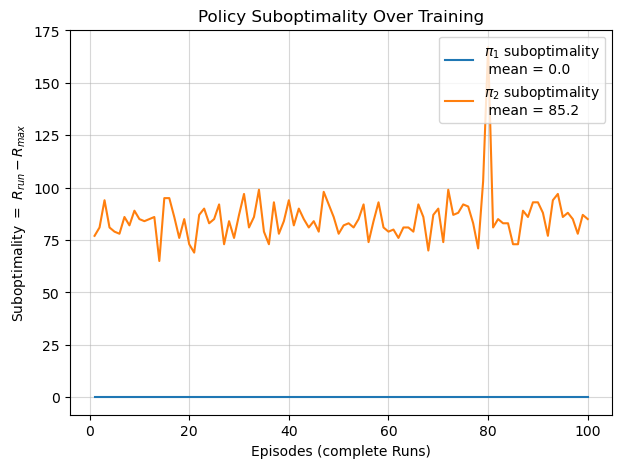

In [5]:
from PPO import ppo_update, RolloutBuffer, evaluate_policy
num_episodes = 100
pi1_mean_reward, pi1_reward = evaluate_policy(policy_oppo, env_oppo, n_episodes=num_episodes)
pi2_mean_reward, pi2_reward = evaluate_policy(policy_oppo2, env_oppo, n_episodes=num_episodes)

plot_suboptimality(
    pi1_reward,
    pi2_reward,
    200,
)  # in cartpole, 200 is the maximum reward

In [6]:
from pairs_generator import sample_preference_pairs
traj1 = generate_trajectory(policy_oppo, env_oppo, max_steps=1000)
traj2 = generate_trajectory(policy_oppo2, env_oppo2, max_steps=1000)

print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")
print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")

prefs = sample_preference_pairs(policy_oppo, policy_oppo2, env_oppo, K=200) # Need to define K elsewhere as hyperparameter
print(f"Collected {len(prefs)} preference pairs.")

π₁ → length 200, total reward 200.0
π₂ → length 107, total reward 107.0
Collected 200 preference pairs.


In [7]:
from DPO import DPO_training
lr_DPO=0.1

policy_DPO=Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
policy_ref=policy_oppo
opt_DPO    = torch.optim.Adam(policy_DPO.parameters(), lr=lr_DPO)
policy_DPO.load_state_dict(torch.load("pi_DPO_final.pth"))
beta=0.5

DPO_training(policy_DPO,policy_ref,prefs,beta,opt_DPO,nb_epochs=400)




c:\Users\flako\Desktop\MA2\RL\Cloned_Project\RL-RLHF\pairs_generator.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.tensor([step["state"] for step in trajectory], dtype=torch.float32).to(device)


Epoch 0: DPO Loss = 41.6698
Epoch 10: DPO Loss = 0.7128
Epoch 20: DPO Loss = 0.7954
Epoch 30: DPO Loss = 0.8270
Epoch 40: DPO Loss = 0.7894
Epoch 50: DPO Loss = 0.7101
Epoch 60: DPO Loss = 0.6464
Epoch 70: DPO Loss = 0.6247
Epoch 80: DPO Loss = 0.6099
Epoch 90: DPO Loss = 0.6060
Epoch 100: DPO Loss = 0.6034
Epoch 110: DPO Loss = 0.6006
Epoch 120: DPO Loss = 0.5975
Epoch 130: DPO Loss = 0.5945
Epoch 140: DPO Loss = 0.5928
Epoch 150: DPO Loss = 0.5916
Epoch 160: DPO Loss = 0.5905
Epoch 170: DPO Loss = 0.5894
Epoch 180: DPO Loss = 0.5882
Epoch 190: DPO Loss = 0.5869
Epoch 200: DPO Loss = 0.5856
Epoch 210: DPO Loss = 0.5842
Epoch 220: DPO Loss = 0.5835
Epoch 230: DPO Loss = 0.5831
Epoch 240: DPO Loss = 0.5828
Epoch 250: DPO Loss = 0.5825
Epoch 260: DPO Loss = 0.5823
Epoch 270: DPO Loss = 0.5820
Epoch 280: DPO Loss = 0.5818
Epoch 290: DPO Loss = 0.5815
Epoch 300: DPO Loss = 0.5813
Epoch 310: DPO Loss = 0.5811
Epoch 320: DPO Loss = 0.5808
Epoch 330: DPO Loss = 0.5806
Epoch 340: DPO Loss = 0.

In [8]:
from Generate_traj_func import generate_trajectory,plot_trajectory_performance, plot_suboptimality
env_oppo.reset()
traj_DPO=generate_trajectory(policy_DPO,env_oppo2,max_steps=1000)
print(f"π₁ → length {len(traj_DPO)}, total reward {sum(s['reward'] for s in traj_DPO):.1f}")
plot_trajectory_performance(traj_DPO,traj_DPO)

from PPO import ppo_update, RolloutBuffer, evaluate_policy
num_episodes = 100
pi1_mean_reward, pi1_reward = evaluate_policy(policy_DPO, env_oppo, n_episodes=num_episodes)
pi2_mean_reward, pi2_reward = evaluate_policy(policy_ref, env_oppo, n_episodes=num_episodes)

plot_suboptimality(
    pi1_reward,
    pi2_reward,
    200,
)  # in cartpole, 200 is the maximum reward

ImportError: cannot import name 'plot_trajectory_performance' from 'Generate_traj_func' (c:\Users\flako\Desktop\MA2\RL\Cloned_Project\RL-RLHF\Generate_traj_func.py)

In [ ]:
torch.save(policy_oppo.state_dict(), "pi_oppo_final.pth")
print("Saved final policy as pi_oppo_final.pth")
torch.save(policy_oppo2.state_dict(), "pi_oppo2_final.pth")
print("Saved final policy as pi_oppo2_final.pth")
torch.save(policy_DPO.state_dict(), "pi_DPO_final.pth")
print("Saved final policy as pi_DPO_final.pth")

Saved final policy as pi_oppo_final.pth
Saved final policy as pi_oppo2_final.pth
Saved final policy as pi_DPO_final.pth
